# MHAR-ReCov Spillover Analysis with LASSO on PIT-Transformed Realized Covariances



### Model Description

To analyze the role of covariances in the volatility transmission mechanism across electricity markets, we use the MHAR-ReCov model, as proposed by Fengler and Gisler (2015). This model incorporates realized variances and covariances to account for interconnectedness between markets driven by common informational shocks.

The model is specified as:

$$
\tilde{Y}_t = \tilde{\beta}_0 + \sum_{h \in \{1,7,30\}} \tilde{\beta}_h \tilde{Y}_{h,t-1} + \tilde{\epsilon}_t
$$

Where:

- $ \tilde{Y}_t = \text{vech}(\text{ReCov}_t) $ is the half-vectorized $K$-dimensional daily realized covariance matrix, computed from high-frequency data of $N$ electricity markets.
- $ K = \frac{N(N+1)}{2} $ is the number of unique elements in the symmetric covariance matrix.
- $ \tilde{\beta}_0 $ is a vector of intercepts of length $K$.
- $ \tilde{\beta}_h $ are $K \times K$ coefficient matrices for $h = 1$ (daily), $h = 7$ (weekly), and $h = 30$ (monthly) lags.
- $ \tilde{\epsilon}_t $ is a $K \times 1$ innovation vector with zero mean and finite variance.

### Estimation

- The model is estimated using **LASSO** (Least Absolute Shrinkage and Selection Operator), allowing for regularization and variable selection in high-dimensional settings.
- The estimation is done on the **full sample** of realized covariance matrices.




### Step 1: Select and Load PIT-transformed vech Dataset

We use previously computed PIT-transformed realized covariance matrices. Each row represents the half-vectorized lower triangle (vech) of the daily covariance matrix.

In [1]:
import random
from sklearn.model_selection import KFold   
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
import numpy as np
from joblib import Parallel, delayed

In [2]:
# Set seed
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Select dataset from Europe or from Australia

option_selector = widgets.Dropdown(
    options=['europe', 'australia'],
    value='europe',
    description='Dataset:',
)
button = widgets.Button(description="Load Dataset", button_style='success', icon='check')

def on_button_click(b):
    global pit_vech
    clear_output(wait=True)
    display(option_selector, button)
    selected_option = option_selector.value
    file_path = f"parquet_files/pit_transformed_vech_{selected_option}.parquet"
    try:
        pit_vech = pd.read_parquet(file_path)
        print(f"✅ Loaded: {file_path}")
        display(pit_vech.head())
    except Exception as e:
        print(f"❌ Failed to load: {e}")

button.on_click(on_button_click)
display(option_selector, button)

Dropdown(description='Dataset:', options=('europe', 'australia'), value='europe')

Button(button_style='success', description='Load Dataset', icon='check', style=ButtonStyle())

,BZN|ES,BZN|FR-BZN|ES,BZN|FR,BZN|PT-BZN|ES,BZN|PT-BZN|FR,BZN|PT
2021-05-21,-1.228818,-1.092488,-0.470493,-1.217797,-1.228818,-1.221454
2021-05-22,-1.374748,-1.164787,-0.682148,-1.344093,-1.086195,-1.352723
2021-05-23,-1.322947,-1.105205,-0.426281,-1.274471,-1.040308,-1.290294
2021-05-24,-1.239990,-0.930160,-0.541632,-1.185592,-0.867669,-1.210532
2021-05-25,-1.748117,-1.352723,-1.203330,-1.732314,-1.331334,-1.748117


 ## Step 2: Construct MHAR Regressors (Lags at 1, 7, 30)

 We construct lagged versions of the PIT-transformed vector at lags 1, 7, and 30 days, then concatenate them to form the full MHAR regressor matrix.


In [4]:
# Create MHAR lags at horizons: 1, 7, 30
def create_mhar_lags(df, horizons=[1, 7, 30]):
    blocks = []
    for h in horizons:                       # keep 1 → 7 → 30 order
        block = df.shift(h).add_suffix(f"_lag{h}")
        blocks.append(block)
    df_lagged = pd.concat(blocks, axis=1)
    # Final X-matrix: lag-1 cols, lag-7 cols, lag-30 cols
    return pd.concat([df, df_lagged], axis=1).dropna()


mhar_data = create_mhar_lags(pit_vech)
X = mhar_data.drop(columns=pit_vech.columns)
Y = mhar_data[pit_vech.columns]


In [5]:
K = Y.shape[1]
print(X.columns[:3], X.columns[K:K+3], X.columns[-3:])


Index(['BZN|ES_lag1', 'BZN|FR-BZN|ES_lag1', 'BZN|FR_lag1'], dtype='object') Index(['BZN|ES_lag7', 'BZN|FR-BZN|ES_lag7', 'BZN|FR_lag7'], dtype='object') Index(['BZN|PT-BZN|ES_lag30', 'BZN|PT-BZN|FR_lag30', 'BZN|PT_lag30'], dtype='object')


### Step 3: Fit LASSO Regressions

We estimate a separate LASSO regression for each component of the PIT-transformed vech using the MHAR lag structure as regressors.
This enforces sparsity and prevents overfitting when estimating high-dimensional systems.


In [6]:
from sklearn.linear_model import MultiTaskLassoCV        # new import

alphas = None        # let the solver build the same λ-path glmnet does
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)  # 5-fold CV, seeded

mta = MultiTaskLassoCV(cv=cv,
                       random_state=SEED,
                       tol=1e-10,          # glmnet’s thresh
                       max_iter=1_000_000, # glmnet’s maxit
                       alphas=alphas)      # leave None or keep your grid

mta.fit(X.values, Y.values)                # shapes: (n,3K) and (n,K)

betas      = mta.coef_                     # shape K × 3K
intercepts = mta.intercept_                # length K


### Step 4: Compute Residual Covariance Matrix

After estimating the MHAR-LASSO model, we compute in-sample residuals and use them to estimate the residual covariance matrix needed for spillover analysis.


In [7]:
Y_hat = X @ betas.T + intercepts
residuals = Y.values - Y_hat
Sigma = residuals.T @ residuals / residuals.shape[0]   # ε′ε / n



### Step 5: Compute Generalized Variance Decomposition (GVD)

We compute the 1-step ahead GVD using generalized forecast error variance decomposition based on Diebold & Yilmaz (2012). This tells us how much of forecast error variance in variable *i* is explained by shocks to variable *j*.


In [8]:
K = Y.shape[1]
H = 1  # horizon

# Build MA(1) coefficients from MHAR
Phi_mhar = np.zeros((1, K, K))
B_d, B_w, B_m = np.split(betas, 3, axis=1)   # each is K × K

Phi_mhar[0] = B_d + B_w / 7 + B_m / 30       # Φ₁ = β¹ + β⁷/7 + β³⁰/30


# Compute A matrices
A = [np.eye(K)]
for h in range(1, H+1):
    A_h = np.zeros((K, K))
    for j in range(min(h, Phi_mhar.shape[0])):
        A_h += Phi_mhar[j] @ A[h - j - 1]
    A.append(A_h)

# GVD Computation
theta_g = np.zeros((K, K))
sigma_diag_inv = np.diag(1 / np.diag(Sigma))

for i in range(K):
    e_i = np.zeros(K)
    e_i[i] = 1
    denom = sum([e_i @ A[h] @ Sigma @ A[h].T @ e_i for h in range(H)])
    for j in range(K):
        e_j = np.zeros(K)
        e_j[j] = 1
        numer = sum([(e_i @ A[h] @ Sigma @ e_j)**2 for h in range(H)])
        theta_g[i, j] = sigma_diag_inv[j, j] * numer / denom

theta_g_normalized = theta_g / theta_g.sum(axis=1, keepdims=True)




 ## Step 6: Compute Directional and Net Spillovers

In [9]:
spillover_matrix = theta_g_normalized * 100
TSI = 100 * (np.sum(theta_g_normalized) - np.trace(theta_g_normalized)) / K


In [10]:
# TABLE
# Base setup
label_names = pit_vech.columns.tolist()
K = len(label_names)

# Convert normalized GVD matrix to percentages
spillover_matrix = theta_g_normalized * 100

# Directional spillovers
directional_to = spillover_matrix.sum(axis=0) - np.diag(spillover_matrix)
directional_from = spillover_matrix.sum(axis=1) - np.diag(spillover_matrix)
net_directional = directional_to - directional_from

# Construct spillover table
spillover_table = pd.DataFrame(spillover_matrix, index=label_names, columns=label_names)
spillover_table["Directional FROM others"] = directional_from
spillover_table.loc["Directional TO others"] = list(directional_to) + [directional_to.sum()]
spillover_table.loc["NET Directional"] = list(net_directional) + [np.nan]

# Total Spillover Index
TSI = 100 * (np.sum(theta_g_normalized) - np.trace(theta_g_normalized)) / K

# Display results
display(spillover_table.round(2))

# Caption
from IPython.display import Markdown
caption = f"""
**Table X**: Spillovers based on MHAR-ReCov using PIT-transformed realized covariances (vech format).

This table reports the estimated forecast error variance spillovers across markets for a 1-day horizon.
Each cell $(i, j)$ shows the contribution of shocks from variable $j$ to the forecast error variance of variable $i$.

**Total Spillover Index (TSI)** = **{TSI:.2f}%**
"""
display(Markdown(caption))



,BZN|ES,BZN|FR-BZN|ES,BZN|FR,BZN|PT-BZN|ES,BZN|PT-BZN|FR,BZN|PT,Directional FROM others
BZN|ES,28.44,10.54,2.69,24.27,8.28,25.77,71.56
BZN|FR-BZN|ES,12.13,32.73,6.25,9.70,28.76,10.44,67.27
BZN|FR,5.95,12.01,62.83,4.52,9.54,5.15,37.17
BZN|PT-BZN|ES,24.36,8.46,2.05,28.54,9.92,26.67,71.46
BZN|PT-BZN|FR,9.69,29.26,5.06,11.58,33.30,11.11,66.70
BZN|PT,25.35,8.92,2.29,26.14,9.33,27.97,72.03
Directional TO others,77.47,69.19,18.35,76.22,65.84,79.13,386.19
NET Directional,5.91,1.91,-18.82,4.75,-0.86,7.10,NaN



**Table X**: Spillovers based on MHAR-ReCov using PIT-transformed realized covariances (vech format).

This table reports the estimated forecast error variance spillovers across markets for a 1-day horizon.
Each cell $(i, j)$ shows the contribution of shocks from variable $j$ to the forecast error variance of variable $i$.

**Total Spillover Index (TSI)** = **64.37%**


### Step 7: Bootstrap standard errors

In [11]:
pit_vech = pd.read_parquet(f"parquet_files/pit_transformed_vech_{option_selector.value}.parquet")

# Load labels
import json
with open(f"parquet_files/vech_labels_{option_selector.value}.json", "r") as f:
    vech_labels = json.load(f)
    
pit_vech.columns = vech_labels

In [12]:
# Settings
n_bootstrap = 1000
block_size = 10
H = 1
alphas = np.logspace(-4, 1, 50)
pit_vech.columns = vech_labels
label_names = pit_vech.columns.tolist()
K = len(label_names)
labels = pit_vech.columns
np.random.seed(42)

In [13]:
# Block bootstrap indices
def block_bootstrap_indices(n_obs, block_size):
    n_blocks = int(np.ceil(n_obs / block_size))
    block_starts = np.random.randint(0, n_obs - block_size + 1, size=n_blocks)
    indices = []
    for start in block_starts:
        indices.extend(range(start, start + block_size))
    return indices[:n_obs]


In [14]:
assert list(pit_vech.columns) == vech_labels, "Column order mismatch!"


In [15]:
# Bootstrap iteration

def single_bootstrap(seed):
    np.random.seed(seed)
    indices = block_bootstrap_indices(len(pit_vech), block_size)
    sample = pit_vech.iloc[indices]

    # MHAR lags
    def create_mhar_lags(df, horizons=[1, 7, 30]):
        df_lagged = pd.concat([df.shift(h).add_suffix(f"_lag{h}") for h in horizons], axis=1)
        return pd.concat([df, df_lagged], axis=1).dropna()

    data = create_mhar_lags(sample)
    X = data.drop(columns=pit_vech.columns)
    Y = data[pit_vech.columns]

    # Fit LASSO
    def fit_lasso(y):
        model = LassoCV(alphas=alphas, cv=5).fit(X, y)
        return model.coef_, model.intercept_

    results = [fit_lasso(Y[col]) for col in Y.columns]
    betas = np.array([r[0] for r in results])
    intercepts = np.array([r[1] for r in results])
    Y_hat = X @ betas.T + intercepts
    residuals = Y.values - Y_hat
    Sigma = np.cov(residuals.T)
    
    # Build Phi (sum of 3 blocks)
    Phi_mhar = np.zeros((1, K, K))
    for i in range(K):
        Phi_mhar[0, i, :] = betas[i, :K] + betas[i, K:2*K] + betas[i, 2*K:]

    A = [np.eye(K)]
    for h in range(1, H+1):
        A_h = np.zeros((K, K))
        for j in range(min(h, Phi_mhar.shape[0])):
            A_h += Phi_mhar[j] @ A[h - j - 1]
        A.append(A_h)

    # GVD
    theta_g = np.zeros((K, K))
    sigma_diag_inv = np.diag(1 / np.diag(Sigma))

    for i in range(K):
        e_i = np.zeros(K)
        e_i[i] = 1
        denom = sum([e_i @ A[h] @ Sigma @ A[h].T @ e_i for h in range(H)])
        for j in range(K):
            e_j = np.zeros(K)
            e_j[j] = 1
            numer = sum([(e_i @ A[h] @ Sigma @ e_j)**2 for h in range(H)])
            theta_g[i, j] = sigma_diag_inv[j, j] * numer / denom

    theta_g_normalized = theta_g / theta_g.sum(axis=1, keepdims=True)
    tsi = 100 * (np.sum(theta_g_normalized) - np.trace(theta_g_normalized)) / K
    return theta_g_normalized, tsi


In [16]:
# Run bootstrap
seeds = np.random.randint(0, 1_000_000, size=n_bootstrap)
results = Parallel(n_jobs=-1)(delayed(single_bootstrap)(s) for s in tqdm(seeds))

theta_g_bootstrap = np.array([r[0] for r in results])
TSI_bootstrap = np.array([r[1] for r in results])


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s]


In [17]:
# Point estimates already from main run: theta_g_normalized
theta_g_mean = theta_g_bootstrap.mean(axis=0) * 100
theta_g_se = theta_g_bootstrap.std(axis=0) * 100

TSI_mean = TSI_bootstrap.mean()
TSI_se = TSI_bootstrap.std()

print(f"TSI = {TSI_mean:.2f} ± {TSI_se:.2f}")


TSI = 72.32 ± 1.03


### Step 8: Create and Save Spillover Table



In [18]:
# ---- CONFIGURATION ----
n_bootstrap = theta_g_bootstrap.shape[0]

# Generate vech-style labels: ['NSW', 'QLD', 'QLD-NSW', ...]
label_names = pit_vech.columns.tolist()
K = len(label_names)

spillover_table_bootstrap = pd.DataFrame(index=label_names, columns=label_names)

for i in range(K):
    for j in range(K):
        mean_val = theta_g_mean[i, j]
        se_val = theta_g_se[i, j]
        spillover_table_bootstrap.iloc[i, j] = f"{mean_val:.2f} ± {se_val:.2f}"

K_full = len(label_names)

# ---- COMPUTE MEANS AND STANDARD ERRORS ----
theta_g_mean = theta_g_bootstrap.mean(axis=0) * 100  # shape: (K, K)
theta_g_se = theta_g_bootstrap.std(axis=0) * 100     # shape: (K, K)

# ---- CREATE FORMATTED SPILLOVER TABLE ----
spillover_table_bootstrap = pd.DataFrame(index=label_names, columns=label_names)
for i in range(K):
    for j in range(K):
        mean_val = theta_g_mean[i, j]
        se_val = theta_g_se[i, j]
        spillover_table_bootstrap.iloc[i, j] = f"{mean_val:.2f} ± {se_val:.2f}"

# ---- DIRECTIONAL METRICS ----
directional_to = theta_g_mean.sum(axis=0) - np.diag(theta_g_mean)
directional_from = theta_g_mean.sum(axis=1) - np.diag(theta_g_mean)
net_directional = directional_to - directional_from

# Compute bootstrap SEs for directional components
dir_to_se = theta_g_bootstrap.sum(axis=2) - np.einsum("ijk->ij", theta_g_bootstrap)
dir_from_se = theta_g_bootstrap.sum(axis=1) - np.einsum("ijk->ik", theta_g_bootstrap)
net_se = dir_to_se - dir_from_se

dir_to_row = [f"{v:.2f} ± {s:.2f}" for v, s in zip(directional_to, dir_to_se.std(axis=0) * 100)]
dir_from_col = [f"{v:.2f} ± {s:.2f}" for v, s in zip(directional_from, dir_from_se.std(axis=0) * 100)]
net_row = [f"{v:.2f} ± {s:.2f}" for v, s in zip(net_directional, net_se.std(axis=0) * 100)]

# ---- APPEND ROWS AND COLUMNS ----
spillover_table_bootstrap["Directional FROM others"] = dir_from_col
spillover_table_bootstrap.loc["Directional TO others"] = dir_to_row + [""]
spillover_table_bootstrap.loc["NET Directional"] = net_row + [""]



In [19]:
# Display nicely in Jupyter (monospaced font, centered, bold headers)
styled = (
    spillover_table_bootstrap
    .style
    .set_properties(**{'text-align': 'center', 'font-family': 'monospace'})
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
    .set_caption("**Table X: Spillovers based on MHAR-ReCov (Bootstrap Estimates)**")
)

display(styled)


,nsw_nsw,qld_nsw,qld_qld,sa_nsw,sa_qld,sa_sa,tas_nsw,tas_qld,tas_sa,tas_tas,vic_nsw,vic_qld,vic_sa,vic_tas,vic_vic,Directional FROM others
nsw_nsw,23.58 ± 0.93,8.02 ± 0.68,11.46 ± 0.60,10.03 ± 0.65,2.18 ± 0.34,10.85 ± 0.57,3.71 ± 0.45,1.08 ± 0.20,1.40 ± 0.25,6.23 ± 0.38,4.62 ± 0.48,2.54 ± 0.32,3.47 ± 0.40,2.41 ± 0.31,8.40 ± 0.41,76.42 ± 0.00
qld_nsw,10.13 ± 0.79,29.80 ± 1.35,20.75 ± 0.90,2.15 ± 0.41,7.88 ± 0.71,1.69 ± 0.35,1.46 ± 0.33,2.93 ± 0.46,1.78 ± 0.33,1.41 ± 0.28,4.70 ± 0.47,6.18 ± 0.62,3.65 ± 0.44,1.31 ± 0.28,4.20 ± 0.50,70.20 ± 0.00
qld_qld,14.82 ± 0.71,21.24 ± 0.94,30.50 ± 1.22,2.82 ± 0.37,3.43 ± 0.40,2.65 ± 0.37,1.41 ± 0.28,1.43 ± 0.28,1.15 ± 0.21,2.01 ± 0.32,4.21 ± 0.40,4.23 ± 0.47,2.96 ± 0.32,1.32 ± 0.24,5.83 ± 0.52,69.50 ± 0.00
sa_nsw,9.99 ± 0.70,1.70 ± 0.34,2.17 ± 0.30,23.49 ± 0.94,4.39 ± 0.54,18.03 ± 0.68,2.61 ± 0.37,2.25 ± 0.30,2.06 ± 0.36,3.02 ± 0.30,7.50 ± 0.67,4.08 ± 0.47,4.55 ± 0.54,4.11 ± 0.39,10.05 ± 0.44,76.51 ± 0.00
sa_qld,2.98 ± 0.43,8.53 ± 0.76,3.62 ± 0.41,6.03 ± 0.66,32.29 ± 1.73,2.51 ± 0.39,2.90 ± 0.43,5.61 ± 0.68,1.86 ± 0.37,1.48 ± 0.24,6.46 ± 0.61,15.52 ± 1.00,4.38 ± 0.53,1.20 ± 0.29,4.65 ± 0.49,67.71 ± 0.00
sa_sa,11.98 ± 0.66,1.48 ± 0.31,2.26 ± 0.32,19.99 ± 0.80,2.03 ± 0.35,26.04 ± 0.99,1.98 ± 0.32,1.08 ± 0.20,1.58 ± 0.32,3.47 ± 0.33,5.22 ± 0.55,2.19 ± 0.29,4.54 ± 0.60,3.41 ± 0.37,12.76 ± 0.58,73.96 ± 0.00
tas_nsw,4.25 ± 0.51,1.33 ± 0.30,1.25 ± 0.25,3.00 ± 0.41,2.43 ± 0.39,2.06 ± 0.33,27.03 ± 1.25,4.67 ± 0.54,9.24 ± 0.65,17.20 ± 0.78,7.20 ± 0.55,2.84 ± 0.38,5.79 ± 0.54,6.71 ± 0.56,4.99 ± 0.42,72.97 ± 0.00
tas_qld,1.71 ± 0.29,3.68 ± 0.56,1.75 ± 0.33,3.58 ± 0.39,6.52 ± 0.76,1.55 ± 0.26,6.47 ± 0.68,37.51 ± 2.00,7.68 ± 0.68,1.87 ± 0.34,4.62 ± 0.47,8.57 ± 0.83,2.07 ± 0.35,9.69 ± 0.84,2.73 ± 0.38,62.49 ± 0.00
tas_sa,1.76 ± 0.30,1.76 ± 0.33,1.11 ± 0.19,2.59 ± 0.43,1.70 ± 0.35,1.79 ± 0.35,10.10 ± 0.73,6.06 ± 0.63,29.54 ± 1.42,3.81 ± 0.41,8.52 ± 0.59,1.76 ± 0.34,8.47 ± 0.73,15.85 ± 0.91,5.20 ± 0.44,70.46 ± 0.00
tas_tas,8.10 ± 0.50,1.45 ± 0.28,2.02 ± 0.32,3.94 ± 0.36,1.40 ± 0.24,4.08 ± 0.38,19.51 ± 0.95,1.53 ± 0.29,3.96 ± 0.44,30.65 ± 1.33,5.08 ± 0.43,1.85 ± 0.29,4.10 ± 0.37,4.76 ± 0.53,7.58 ± 0.48,69.35 ± 0.00


In [25]:
# Export to LaTeX 
latex_code = spillover_table_bootstrap.to_latex(index=True, escape=False, caption="Spillovers based on MHAR-ReCov (Bootstrap Estimates)", label="tab:spillovers_bootstrap")
with open("spillover_bootstrap_table.tex", "w") as f:
    f.write(latex_code)


In [ ]:
spillover_table_bootstrap.to_parquet(f"parquet_files/volatility_spillovers_VAR_fullcov_{option_selector.value}.parquet")


## Dynamic Spillover Analysis

In [20]:
# --- Rolling TSI based on MHAR-ReCov ---
from sklearn.linear_model import LassoCV
from tqdm import tqdm

window_size = 365
H = 1  # forecast horizon
alphas = np.logspace(-4, 1, 50)
tsi_series = []
rolling_dates = []

for start in tqdm(range(len(pit_vech) - window_size + 1)):
    end = start + window_size
    window_data = pit_vech.iloc[start:end]

    # Build MHAR lags: 1, 7, 30
    def create_mhar_lags(df, horizons=[1, 7, 30]):
        df_lagged = pd.concat([df.shift(h).add_suffix(f"_lag{h}") for h in horizons], axis=1)
        return pd.concat([df, df_lagged], axis=1).dropna()

    mhardf = create_mhar_lags(window_data)
    if mhardf.empty:
        continue

    X = mhardf.drop(columns=pit_vech.columns).values
    Y = mhardf[pit_vech.columns].values
    K = Y.shape[1]

    # Fit LASSO regressions
    betas = []
    intercepts = []
    for i in range(K):
        model = LassoCV(alphas=alphas, cv=5).fit(X, Y[:, i])
        betas.append(model.coef_)
        intercepts.append(model.intercept_)

    betas = np.array(betas)  # shape: K x (3K)
    intercepts = np.array(intercepts)

    # Residuals and Sigma
    Y_hat = X @ betas.T + intercepts
    residuals = Y - Y_hat
    Sigma = np.cov(residuals.T)
    sigma_diag_inv = np.diag(1 / np.diag(Sigma))

    # Construct A matrices from MHAR
    Phi_mhar = np.zeros((1, K, K))
    for i in range(K):
        Phi_mhar[0, i, :] = betas[i, :K] + betas[i, K:2*K] + betas[i, 2*K:]

    A = [np.eye(K)]
    for h in range(1, H + 1):
        A_h = np.zeros((K, K))
        for j in range(min(h, Phi_mhar.shape[0])):
            A_h += Phi_mhar[j] @ A[h - j - 1]
        A.append(A_h)

    # GVD (theta_g)
    theta_g = np.zeros((K, K))
    for i in range(K):
        e_i = np.zeros(K)
        e_i[i] = 1
        denom = sum([e_i @ A[h] @ Sigma @ A[h].T @ e_i for h in range(H)])
        for j in range(K):
            e_j = np.zeros(K)
            e_j[j] = 1
            numer = sum([(e_i @ A[h] @ Sigma @ e_j)**2 for h in range(H)])
            theta_g[i, j] = sigma_diag_inv[j, j] * numer / denom

    theta_g_normalized = theta_g / theta_g.sum(axis=1, keepdims=True)
    TSI = 100 * (np.sum(theta_g_normalized) - np.trace(theta_g_normalized)) / K

    rolling_dates.append(mhardf.index[-1])
    tsi_series.append(TSI)


100%|██████████| 3166/3166 [43:26<00:00,  1.21it/s]  


In [21]:
# Save rolling TSI as a DataFrame
tsi_df = pd.DataFrame({'Date': rolling_dates, 'TSI': tsi_series})
tsi_df.set_index('Date', inplace=True)
tsi_df.to_parquet(f"parquet_files/rolling_tsi_mhar_recov_{option_selector.value}.parquet")


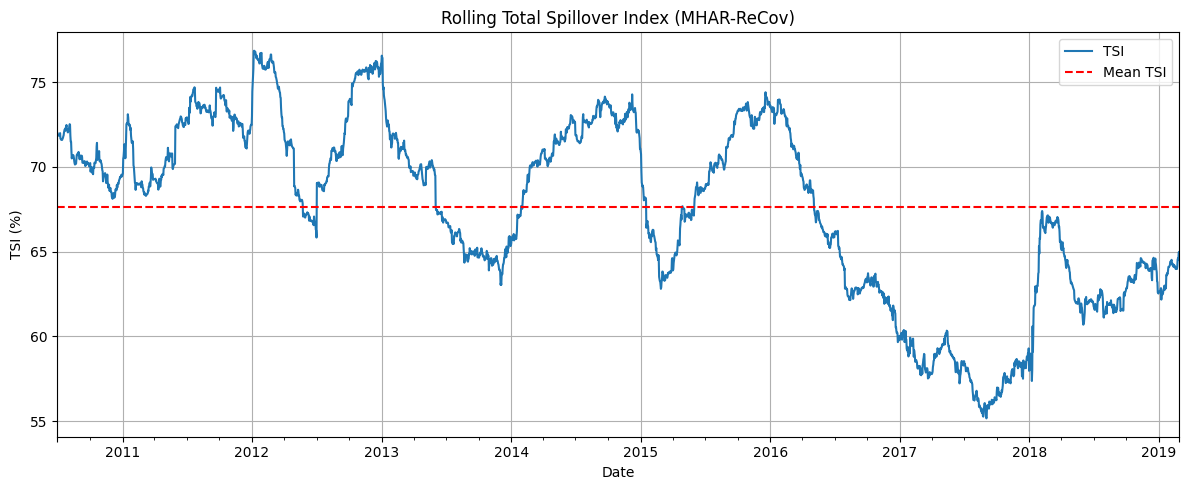

In [22]:
tsi_df.plot(figsize=(12, 5), title='Rolling Total Spillover Index (MHAR-ReCov)', ylabel='TSI (%)')
plt.axhline(tsi_df['TSI'].mean(), color='red', linestyle='--', label='Mean TSI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
